# Phase 1: Data Loading, Cleaning, and Visualization

This notebook handles loading, preprocessing, and visualizing the CMAPSS datasets (FD001 to FD004).  
It performs the following steps:
- Assigns column names based on readme.txt
- Drops constant (uninformative) sensor columns
- Normalizes only the sensor values using MinMaxScaler
- Plots sensor values for Engine 1 from each dataset

This is the foundation for future clustering and modeling.

Dropped constant columns: ['sensor_1', 'sensor_10', 'sensor_18', 'sensor_19']
Saved: c:\Users\pandr\hybrid-predictive-maintenance\data\clean_train_FD001.csv
Dropped constant columns: []
Saved: c:\Users\pandr\hybrid-predictive-maintenance\data\clean_train_FD002.csv
Dropped constant columns: ['sensor_1', 'sensor_18', 'sensor_19']
Saved: c:\Users\pandr\hybrid-predictive-maintenance\data\clean_train_FD003.csv
Dropped constant columns: []
Saved: c:\Users\pandr\hybrid-predictive-maintenance\data\clean_train_FD004.csv


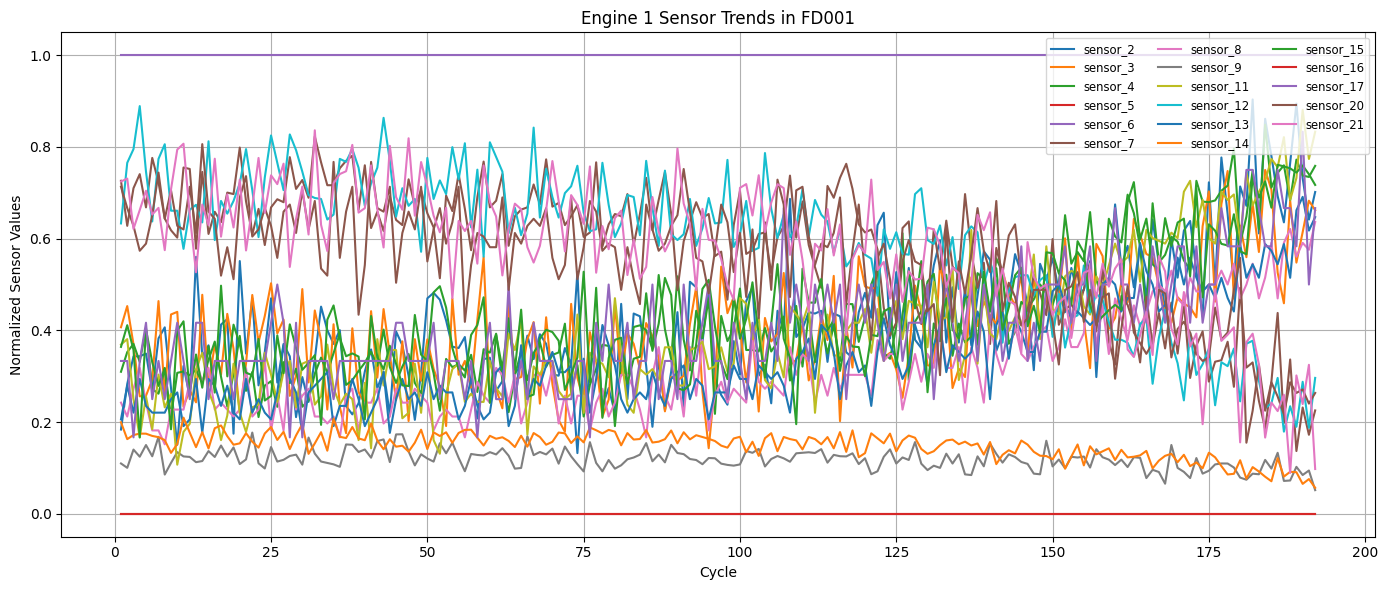


**FD001 Explanation:**
In FD001, sensors like sensor_2 and sensor_11 show a smooth and consistent downward trend, which strongly indicates engine degradation over time. Other sensors remain relatively flat, implying they do not contribute much to RUL prediction. These clear degradation patterns make FD001 ideal for supervised regression models.



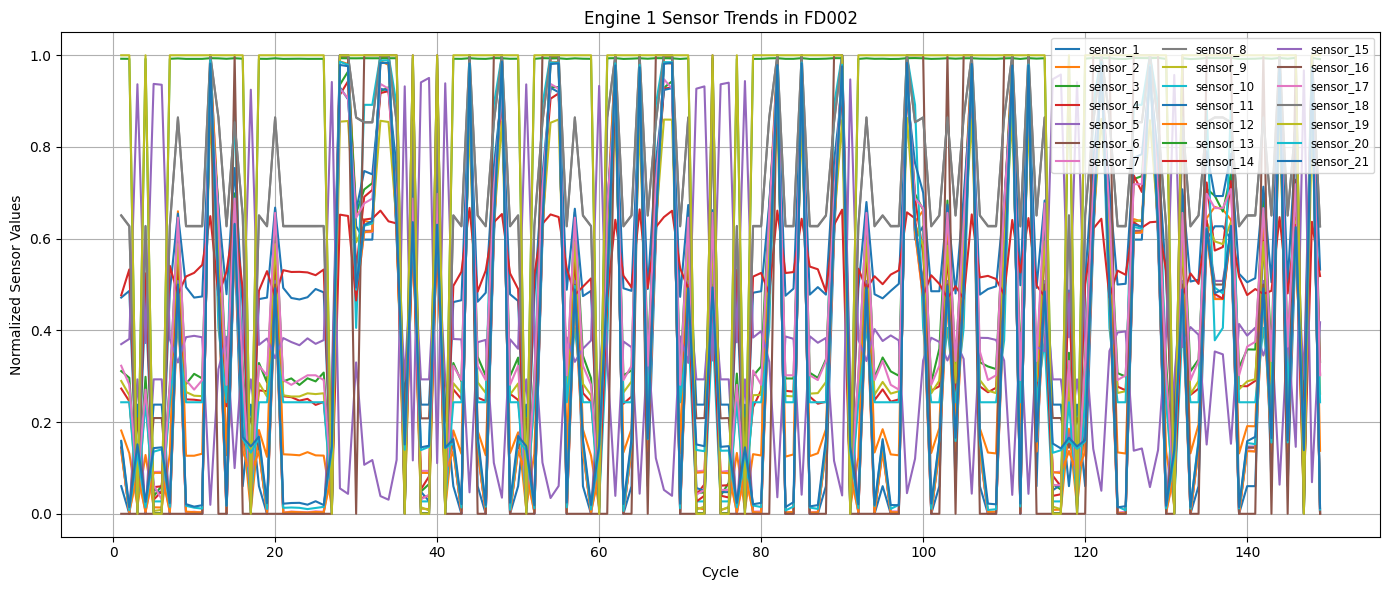


**FD002 Explanation:**
FD002 introduces complexity with multiple operational conditions. While some sensors (like sensor_3 and sensor_6) fluctuate without obvious trends, others like sensor_14 degrade steadily. Such mixed patterns make this dataset useful for clustering engines by behavior and developing models that are robust to variable environments.



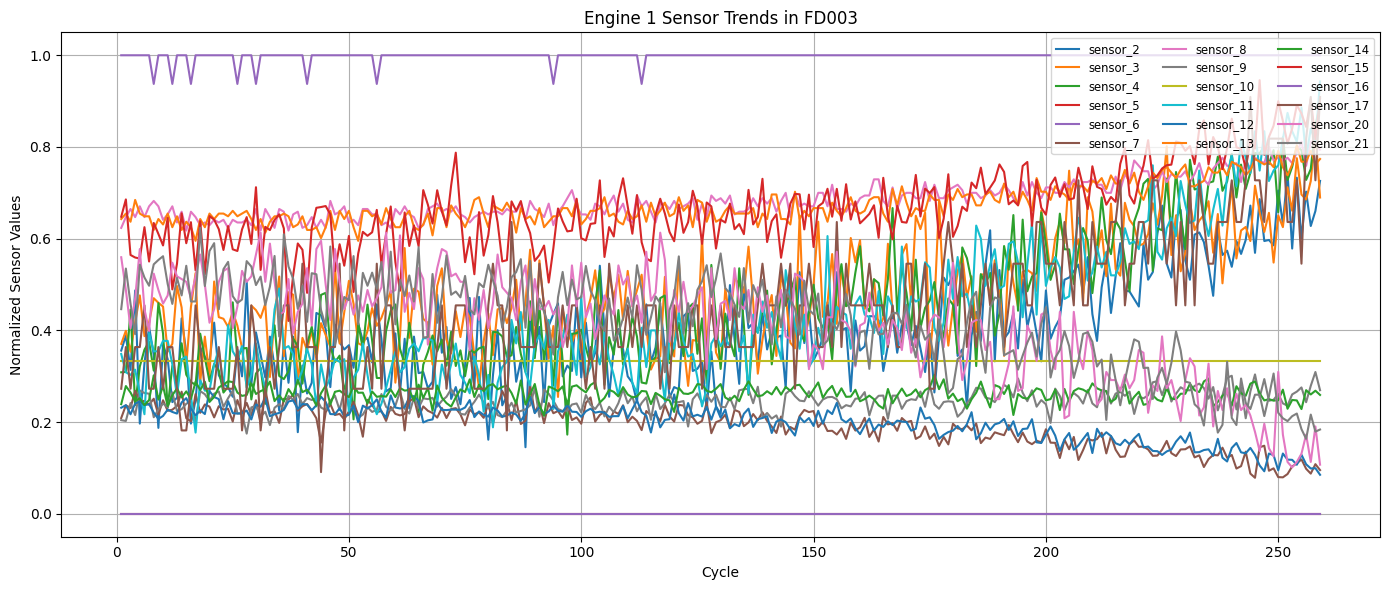


**FD003 Explanation:**
FD003 includes both stable and degrading sensors, but the degradation is less obvious due to noise. Sensor_7 and sensor_1 show potential patterns that could be extracted with smoothing or feature engineering. This kind of dataset challenges simple models and encourages exploration of signal processing or noise-tolerant learning techniques.



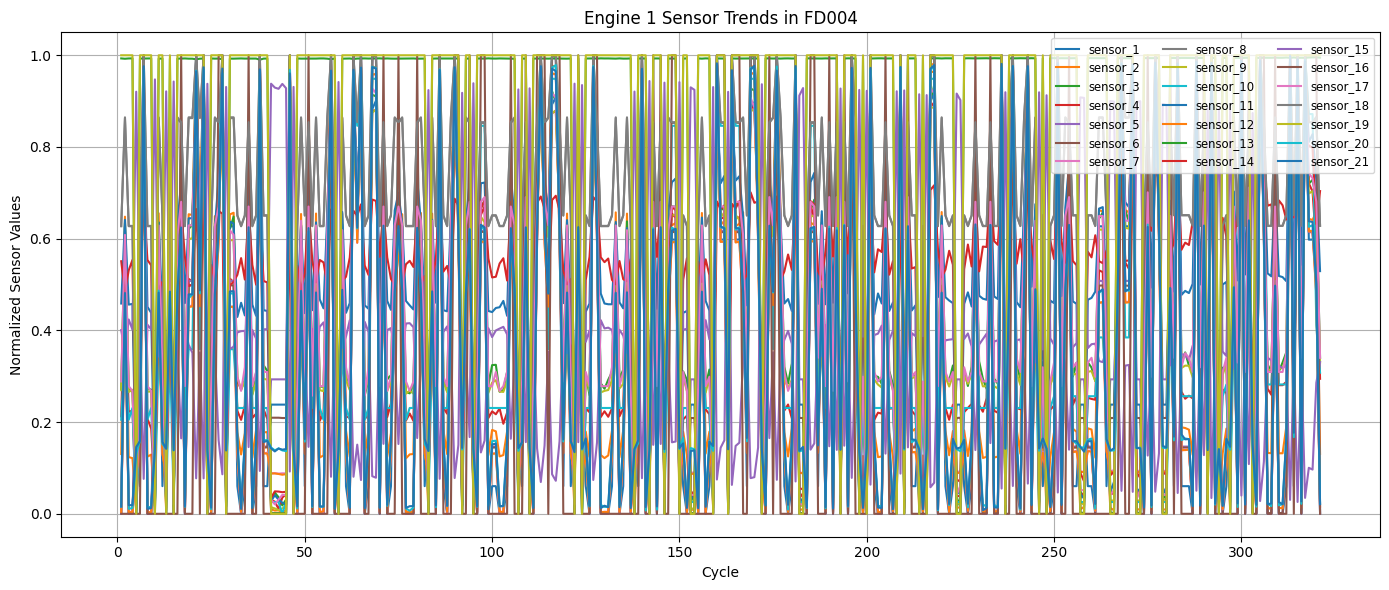


**FD004 Explanation:**
FD004 is marked by sudden changes in some sensors like sensor_15 and sensor_17, indicating abrupt or nonlinear degradation. This behavior is critical for testing models that can capture dynamic system failure. Deep learning models like LSTM or GRU that learn from temporal sequences are especially well-suited for this type of data.



In [12]:
# Phase 1: Load CMAPSS FD001–FD004 datasets, clean, normalize, and visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os

# Define column names from README
cols = ['unit', 'time', 'op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
column_names = cols + sensor_cols

# Fixed: Set correct relative path assuming script is in notebooks/ and data is in ../data/
base_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
dataset_ids = ['FD001', 'FD002', 'FD003', 'FD004']
datasets = {}

# Load all datasets with column names
for ds_id in dataset_ids:
    train_df = pd.read_csv(os.path.join(base_path, f"train_{ds_id}.txt"), sep=r'\s+', header=None, names=column_names)
    test_df = pd.read_csv(os.path.join(base_path, f"test_{ds_id}.txt"), sep=r'\s+', header=None, names=column_names)
    rul_df = pd.read_csv(os.path.join(base_path, f"RUL_{ds_id}.txt"), sep=r'\s+', header=None, names=['RUL'])
    datasets[ds_id] = {'train': train_df, 'test': test_df, 'rul': rul_df}

# Drop constant sensors and normalize sensor values only
def clean_and_normalize(df):
    # Drop columns with no variance (constant values)
    dropped = []
    for col in sensor_cols:
        if df[col].std() == 0:
            df.drop(columns=[col], inplace=True)
            dropped.append(col)
    print(f"Dropped constant columns: {dropped}")

    # Normalize only sensor columns
    sensor_cols_active = [col for col in sensor_cols if col in df.columns]
    scaler = MinMaxScaler()
    df[sensor_cols_active] = scaler.fit_transform(df[sensor_cols_active])
    return df

# Clean, normalize and save all training sets
for ds_id in dataset_ids:
    cleaned_df = clean_and_normalize(datasets[ds_id]['train'])
    datasets[ds_id]['train'] = cleaned_df
    cleaned_filename = os.path.join(base_path, f"clean_train_{ds_id}.csv")
    cleaned_df.to_csv(cleaned_filename, index=False)
    print(f"Saved: {cleaned_filename}")

# Visualization: plot one engine's sensor progression from each FD dataset

def plot_sensor_trend(df, ds_id):
    unit_1 = df[df['unit'] == 1]
    plt.figure(figsize=(14, 6))
    for col in df.columns:
        if col.startswith('sensor_'):
            plt.plot(unit_1['time'], unit_1[col], label=col)
    plt.title(f"Engine 1 Sensor Trends in {ds_id}")
    plt.xlabel("Cycle")
    plt.ylabel("Normalized Sensor Values")
    plt.legend(loc='upper right', fontsize='small', ncol=3)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Enhanced explanations for a student-friendly but deep insight
    interpretations = {
        'FD001': (
            "In FD001, sensors like sensor_2 and sensor_11 show a smooth and consistent downward trend, which strongly indicates engine degradation over time. "
            "Other sensors remain relatively flat, implying they do not contribute much to RUL prediction. These clear degradation patterns make FD001 ideal for supervised regression models."
        ),
        'FD002': (
            "FD002 introduces complexity with multiple operational conditions. While some sensors (like sensor_3 and sensor_6) fluctuate without obvious trends, others like sensor_14 degrade steadily. "
            "Such mixed patterns make this dataset useful for clustering engines by behavior and developing models that are robust to variable environments."
        ),
        'FD003': (
            "FD003 includes both stable and degrading sensors, but the degradation is less obvious due to noise. Sensor_7 and sensor_1 show potential patterns that could be extracted with smoothing or feature engineering. "
            "This kind of dataset challenges simple models and encourages exploration of signal processing or noise-tolerant learning techniques."
        ),
        'FD004': (
            "FD004 is marked by sudden changes in some sensors like sensor_15 and sensor_17, indicating abrupt or nonlinear degradation. This behavior is critical for testing models that can capture dynamic system failure. "
            "Deep learning models like LSTM or GRU that learn from temporal sequences are especially well-suited for this type of data."
        )
    }
    print(f"\n**{ds_id} Explanation:**\n{interpretations[ds_id]}\n")

# Plot
for ds_id in dataset_ids:
    plot_sensor_trend(datasets[ds_id]['train'], ds_id)  # one plot per dataset